# VIX

In [8]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import yfinance as yf
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 設置繁體中文字型
rcParams['font.family'] = 'Microsoft JhengHei'  # 微軟正黑體
rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

In [9]:

# 下載VIX數據
vix = yf.download("^VIX", start="2019-01-01", end="2024-12-30")
vix


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,27.540001,28.530001,23.049999,23.219999,23.219999,0
2019-01-03,25.680000,26.600000,24.049999,25.450001,25.450001,0
2019-01-04,24.360001,24.480000,21.190001,21.379999,21.379999,0
2019-01-07,22.059999,22.709999,20.910000,21.400000,21.400000,0
2019-01-08,20.959999,22.030001,20.090000,20.469999,20.469999,0
...,...,...,...,...,...,...
2024-12-20,24.139999,26.510000,17.820000,18.360001,18.360001,0
2024-12-23,18.090000,20.020000,16.740000,16.780001,16.780001,0
2024-12-24,16.969999,17.040001,14.270000,14.270000,14.270000,0


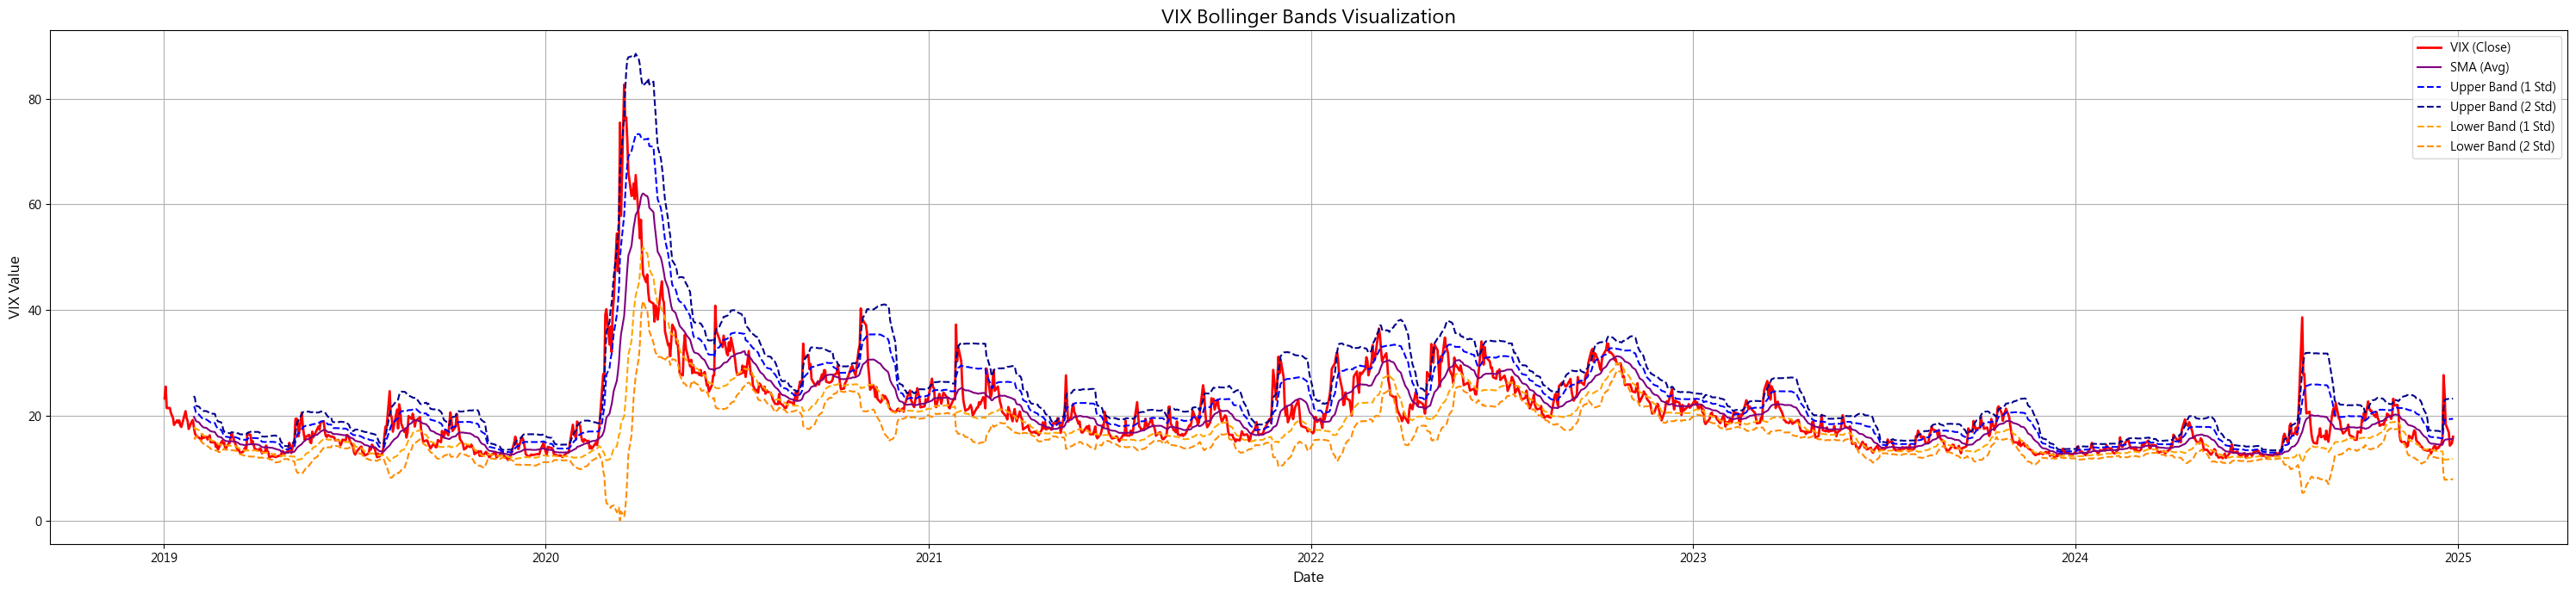

In [10]:
# 計算布林帶函數
def calculate_bollinger_bands(data, window):
    """
    計算布林帶，包含移動平均線 (SMA)、1個和2個標準差的上下軌
    """
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['Upper_Band_1'] = data['SMA'] + 1 * data['Close'].rolling(window=window).std()
    data['Upper_Band_2'] = data['SMA'] + 2 * data['Close'].rolling(window=window).std()
    data['Lower_Band_1'] = data['SMA'] - 1 * data['Close'].rolling(window=window).std()
    data['Lower_Band_2'] = data['SMA'] - 2 * data['Close'].rolling(window=window).std()

# 計算布林帶
calculate_bollinger_bands(vix, window=20)

# 繪製圖表
plt.figure(figsize=(30, 7))

# 繪製VIX收盤價
plt.plot(vix.index, vix['Close'], label="VIX (Close)", color="red", linewidth=2)

# 繪製布林帶
plt.plot(vix.index, vix['SMA'], label="SMA (Avg)", color="purple", linewidth=1.5)
plt.plot(vix.index, vix['Upper_Band_1'], label="Upper Band (1 Std)", color="blue", linestyle="--")
plt.plot(vix.index, vix['Upper_Band_2'], label="Upper Band (2 Std)", color="darkblue", linestyle="--")
plt.plot(vix.index, vix['Lower_Band_1'], label="Lower Band (1 Std)", color="orange", linestyle="--")
plt.plot(vix.index, vix['Lower_Band_2'], label="Lower Band (2 Std)", color="darkorange", linestyle="--")

# 添加標題和標籤
plt.title("VIX Bollinger Bands Visualization", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("VIX Value", fontsize=12)
plt.legend(loc="best")

# 格式化和顯示
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
class VIXBollingerStrategy:
    def __init__(self, data, period=20):
        """
        初始化布林帶策略
        :param data: VIX期貨數據
        :param period: 布林帶周期
        """
        self.data = data.copy()
        self.period = period
        
    def calculate_bollinger_bands(self):
        """計算布林帶"""
        # 計算移動平均線
        self.data['MA'] = self.data['Close'].rolling(window=self.period).mean()
        # 計算標準差
        rolling_std = self.data['Close'].rolling(window=self.period).std()
        
        # 計算布林帶（1個標準差和2個標準差）
        self.data['Upper_Band1'] = self.data['MA'] + rolling_std
        self.data['Lower_Band1'] = self.data['MA'] - rolling_std
        self.data['Upper_Band2'] = self.data['MA'] + 2 * rolling_std
        self.data['Lower_Band2'] = self.data['MA'] - 2 * rolling_std
        
        return self.data
    
    def calculate_signals(self):
        """計算交易信號"""
        # 初始化信號和倉位
        self.data['Signal'] = 0  # 信號欄位用於記錄當天產生的交易信號
        self.data['Position'] = 0  # 倉位欄位用於記錄實際持倉狀態
        
        # 多頭信號條件：從下往上突破第一條布林線上軌（1個標準差）
        long_signal = (self.data['Close'] > self.data['Upper_Band1']) & \
                     (self.data['Close'].shift(1) <= self.data['Upper_Band1'].shift(1))
        
        # 空頭信號條件：從上往下突破第一條布林線下軌（1個標準差）
        short_signal = (self.data['Close'] < self.data['Lower_Band1']) & \
                      (self.data['Close'].shift(1) >= self.data['Lower_Band1'].shift(1))
        
        # 設置信號
        self.data.loc[long_signal, 'Signal'] = 1
        self.data.loc[short_signal, 'Signal'] = -1
        
        # 設置隔日實際倉位
        self.data['Position'] = self.data['Signal'].shift(1)
        self.data['Position'] = self.data['Position'].fillna(0)
        
        # 處理平倉條件
        for i in range(1, len(self.data)):
            if self.data['Position'].iloc[i] == 1:  # 持有多頭
                # 止盈：達到上軌2個標準差
                if self.data['Close'].iloc[i] >= self.data['Upper_Band2'].iloc[i]:
                    self.data.loc[self.data.index[i+1:i+2], 'Position'] = 0  # 隔日平倉
                # 止損：回落到均線
                elif self.data['Close'].iloc[i] <= self.data['MA'].iloc[i]:
                    self.data.loc[self.data.index[i+1:i+2], 'Position'] = 0  # 隔日平倉
                    
            elif self.data['Position'].iloc[i] == -1:  # 持有空頭
                # 止盈：達到下軌2個標準差
                if self.data['Close'].iloc[i] <= self.data['Lower_Band2'].iloc[i]:
                    self.data.loc[self.data.index[i+1:i+2], 'Position'] = 0  # 隔日平倉
                # 止損：回升到均線
                elif self.data['Close'].iloc[i] >= self.data['MA'].iloc[i]:
                    self.data.loc[self.data.index[i+1:i+2], 'Position'] = 0  # 隔日平倉
        
        return self.data
    
    def backtest(self, initial_capital=100000):
        """
        回測策略
        :param initial_capital: 初始資金
        :return: 回測結果
        """
        # 初始化收益計算
        self.data['Returns'] = 0.0
        self.data['Cumulative_Returns'] = 1.0
        
        # 計算每日收益率
        # 使用開盤價計算收益率
        self.data['Open_Return'] = self.data['Open'].pct_change()
        
        # 只在有倉位時計算收益（使用當天的開盤價）
        self.data['Returns'] = self.data['Open_Return'] * self.data['Position']
        
        # 計算累積收益
        self.data['Cumulative_Returns'] = (1 + self.data['Returns']).cumprod()
        
        # 計算策略評估指標
        total_days = len(self.data)
        active_days = (self.data['Position'] != 0).sum()
        
        if total_days > 0:
            total_return = self.data['Cumulative_Returns'].iloc[-1] - 1
            annual_return = total_return / (total_days / 252)
            
            trading_returns = self.data['Returns']
            sharpe_ratio = np.sqrt(252) * (trading_returns.mean() / trading_returns.std()) if len(trading_returns) > 1 else 0
        else:
            total_return = 0
            annual_return = 0
            sharpe_ratio = 0
        
        return {
            'Total Return': total_return,
            'Annual Return': annual_return,
            'Sharpe Ratio': sharpe_ratio,
            'Active Days': active_days,
            'Total Days': total_days
        }
    
    def plot_strategy(self):
        """繪製策略圖表"""
        plt.figure(figsize=(15, 10))
        
        # 繪製價格和布林帶
        plt.subplot(2, 1, 1)
        plt.plot(self.data.index, self.data['Close'], label='VIX')
        plt.plot(self.data.index, self.data['MA'], label=f'{self.period}日均線', color='gray')
        plt.plot(self.data.index, self.data['Upper_Band1'], 'g--', label='上軌(1σ)')
        plt.plot(self.data.index, self.data['Lower_Band1'], 'g--', label='下軌(1σ)')
        plt.plot(self.data.index, self.data['Upper_Band2'], 'r--', label='上軌(2σ)')
        plt.plot(self.data.index, self.data['Lower_Band2'], 'r--', label='下軌(2σ)')
        
        # 標記交易信號（使用Signal而不是Position的變化來標記）
        long_signals = self.data[self.data['Signal'] == 1]
        short_signals = self.data[self.data['Signal'] == -1]
        exits = self.data[self.data['Position'].shift(-1) == 0][self.data['Position'] != 0]
        
        plt.scatter(long_signals.index, long_signals['Close'], 
                   marker='^', color='g', label='做多信號')
        plt.scatter(short_signals.index, short_signals['Close'], 
                   marker='v', color='r', label='做空信號')
        plt.scatter(exits.index, exits['Close'], 
                   marker='s', color='black', label='平倉信號')
        
        plt.title('VIX布林帶策略交易信號 (隔日開盤執行)')
        plt.legend()
        
        # 繪製累積收益
        plt.subplot(2, 1, 2)
        plt.plot(self.data.index, self.data['Cumulative_Returns'], label='策略累積收益')
        plt.title('策略累積收益曲線')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_3732\3521537728.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exits = self.data[self.data['Position'].shift(-1) == 0][self.data['Position'] != 0]


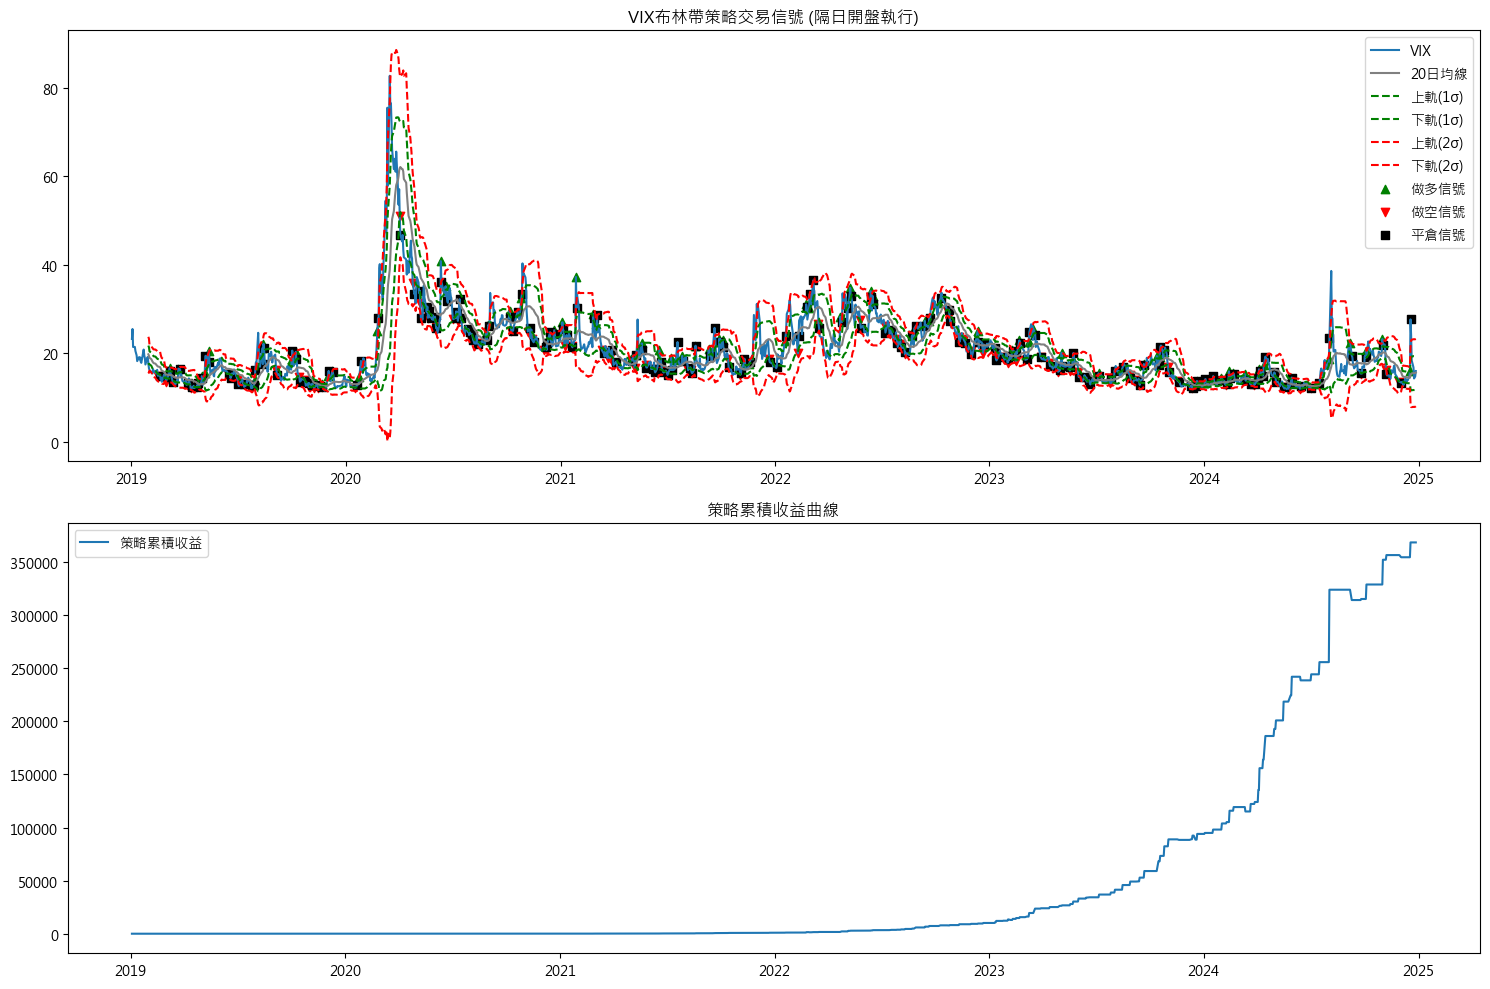

20日布林帶策略回測結果: {'Total Return': 368558.8741504228, 'Annual Return': 61589.41398269665, 'Sharpe Ratio': 3.829926087897198, 'Active Days': 199, 'Total Days': 1508}


C:\Users\User\AppData\Local\Temp\ipykernel_3732\3521537728.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exits = self.data[self.data['Position'].shift(-1) == 0][self.data['Position'] != 0]


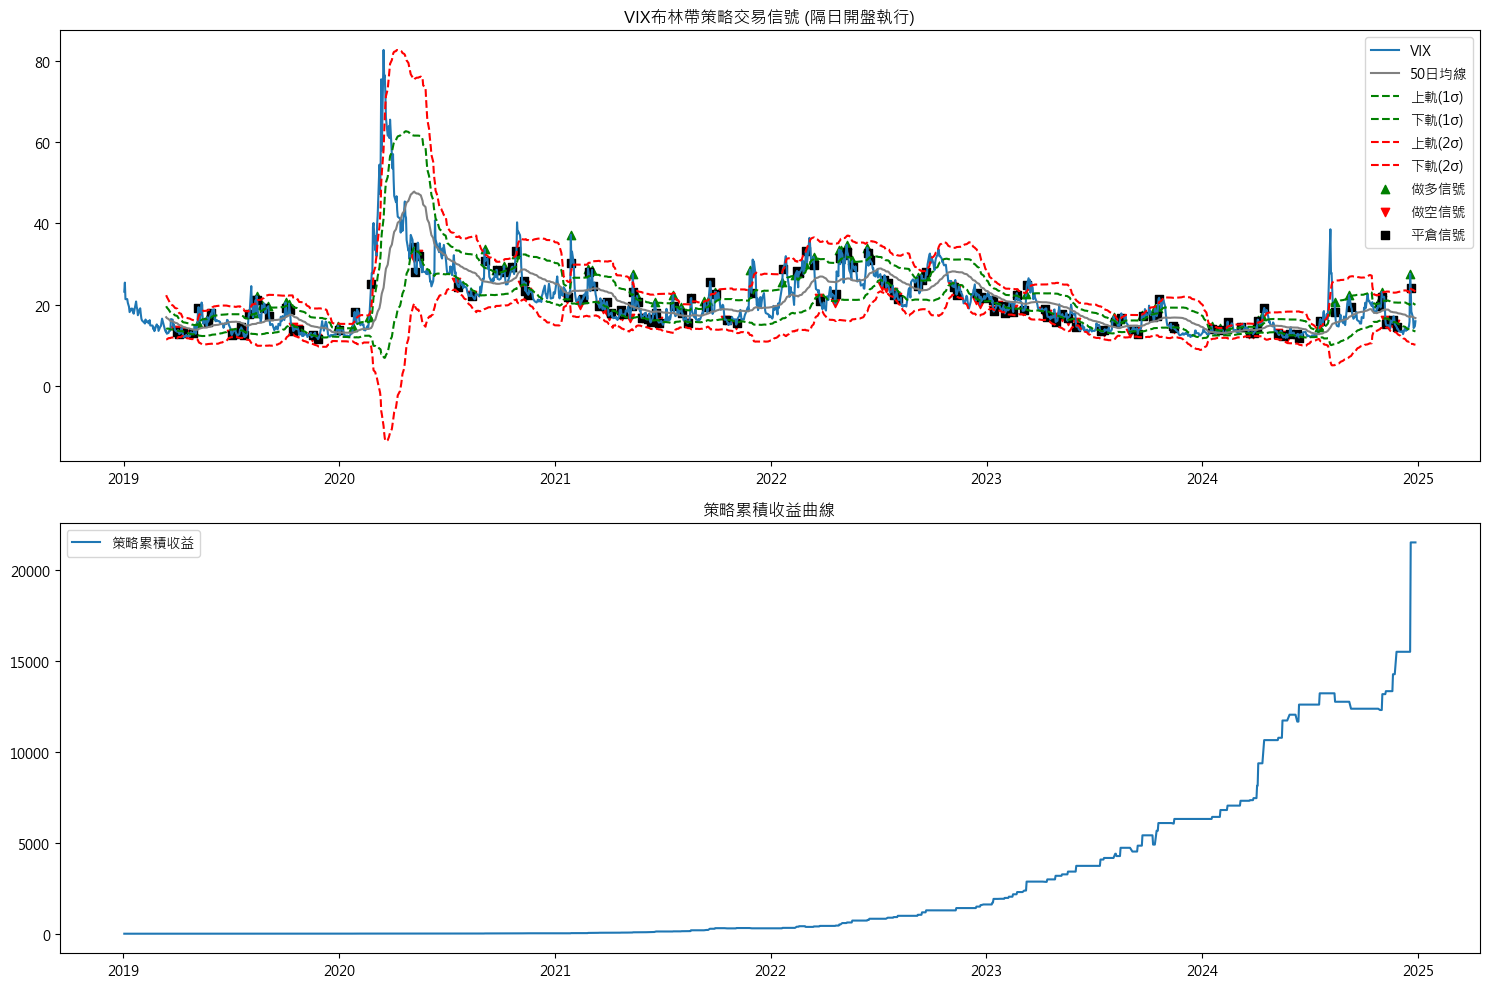

50日布林帶策略回測結果: {'Total Return': 21532.593437946787, 'Annual Return': 3598.284845068031, 'Sharpe Ratio': 3.219494804598785, 'Active Days': 143, 'Total Days': 1508}


C:\Users\User\AppData\Local\Temp\ipykernel_3732\3521537728.py:127: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exits = self.data[self.data['Position'].shift(-1) == 0][self.data['Position'] != 0]


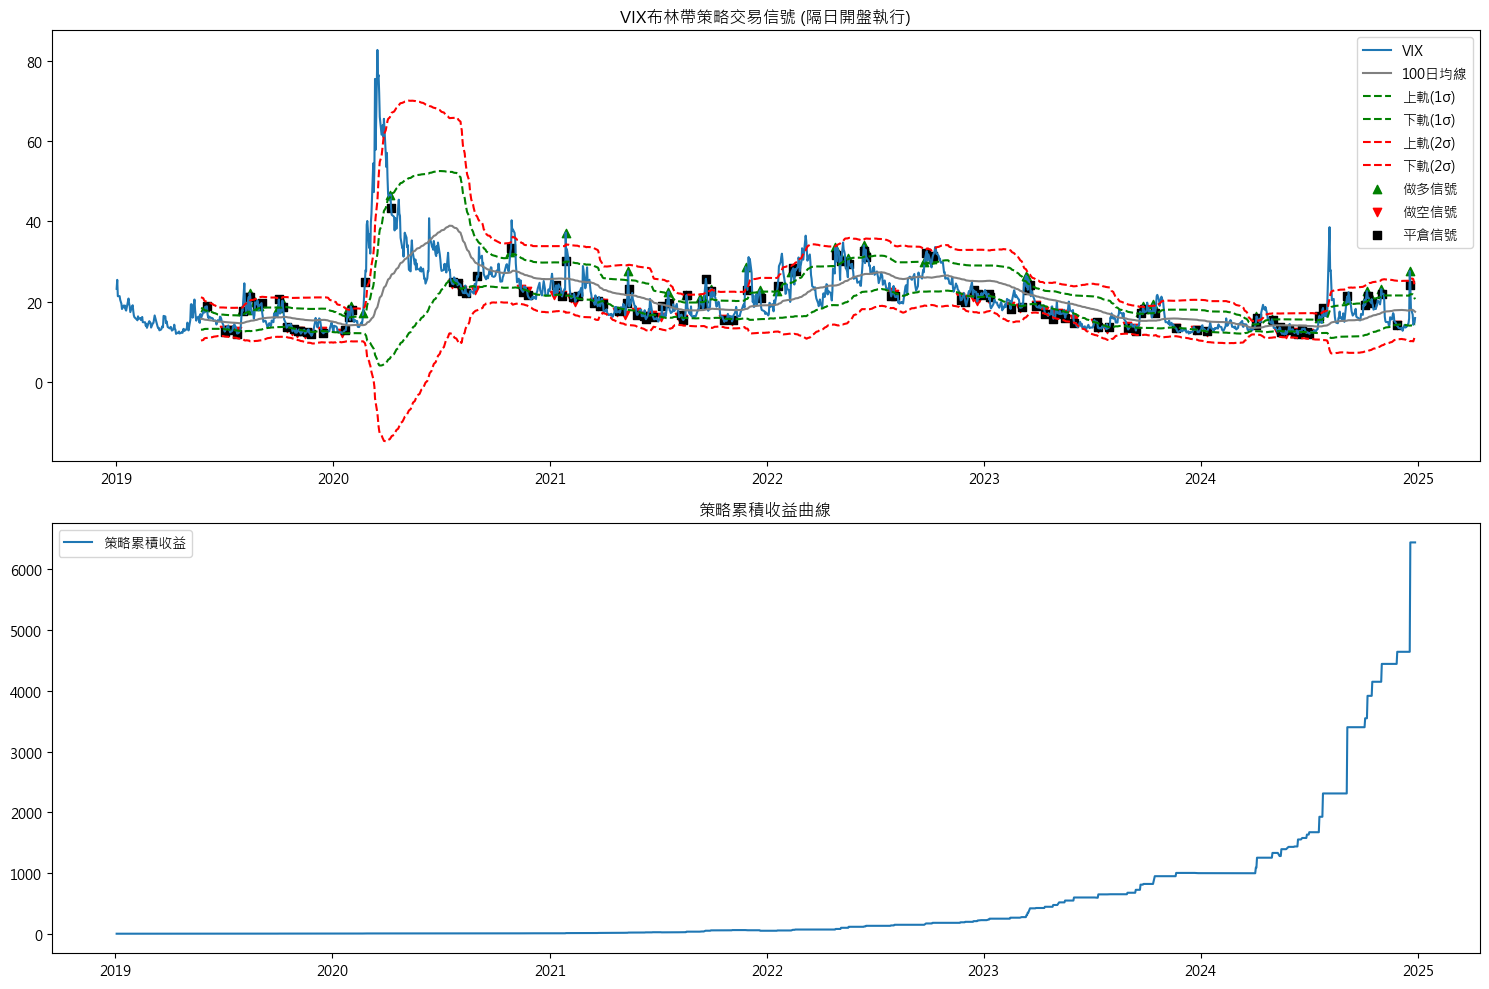

100日布林帶策略回測結果: {'Total Return': 6442.835751808472, 'Annual Return': 1076.6542503022115, 'Sharpe Ratio': 2.977994828964143, 'Active Days': 120, 'Total Days': 1508}


In [12]:
def run_strategy(vix_data, period=20):
    strategy = VIXBollingerStrategy(vix_data, period=period)
    strategy.calculate_bollinger_bands()
    strategy.calculate_signals()
    results = strategy.backtest()
    strategy.plot_strategy()
    print(f"{period}日布林帶策略回測結果:", results)
    return strategy

# 對多個週期進行回測
periods = [20, 50, 100]
strategies = {}
for period in periods:
    strategies[period] = run_strategy(vix, period)

# VXX - (VIX ETF)

In [ ]:

# 下載VXX數據
vxx = yf.download("VXX", start="2019-01-01", end="2024-12-30")
vxx


In [ ]:
# 計算布林帶函數
def calculate_bollinger_bands(data, window):
    """
    計算布林帶，包含移動平均線 (SMA)、1個和2個標準差的上下軌
    """
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['Upper_Band_1'] = data['SMA'] + 1 * data['Close'].rolling(window=window).std()
    data['Upper_Band_2'] = data['SMA'] + 2 * data['Close'].rolling(window=window).std()
    data['Lower_Band_1'] = data['SMA'] - 1 * data['Close'].rolling(window=window).std()
    data['Lower_Band_2'] = data['SMA'] - 2 * data['Close'].rolling(window=window).std()

# 計算布林帶
calculate_bollinger_bands(vxx, window=20)

# 繪製圖表
plt.figure(figsize=(30, 7))

# 繪製vxx收盤價
plt.plot(vxx.index, vxx['Close'], label="vxx (Close)", color="red", linewidth=2)

# 繪製布林帶
plt.plot(vxx.index, vxx['SMA'], label="SMA (Avg)", color="purple", linewidth=1.5)
plt.plot(vxx.index, vxx['Upper_Band_1'], label="Upper Band (1 Std)", color="blue", linestyle="--")
plt.plot(vxx.index, vxx['Upper_Band_2'], label="Upper Band (2 Std)", color="darkblue", linestyle="--")
plt.plot(vxx.index, vxx['Lower_Band_1'], label="Lower Band (1 Std)", color="orange", linestyle="--")
plt.plot(vxx.index, vxx['Lower_Band_2'], label="Lower Band (2 Std)", color="darkorange", linestyle="--")

# 添加標題和標籤
plt.title("vxx Bollinger Bands Visualization", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("vxx Value", fontsize=12)
plt.legend(loc="best")

# 格式化和顯示
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
class VIXBollingerStrategy:
    def __init__(self, data, period=20):
        """
        初始化布林帶策略
        :param data: VIX期貨數據
        :param period: 布林帶周期
        """
        self.data = data.copy()
        self.period = period
        
    def calculate_bollinger_bands(self):
        """計算布林帶"""
        # 計算移動平均線
        self.data['MA'] = self.data['Close'].rolling(window=self.period).mean()
        # 計算標準差
        rolling_std = self.data['Close'].rolling(window=self.period).std()
        
        # 計算布林帶（1個標準差和2個標準差）
        self.data['Upper_Band1'] = self.data['MA'] + rolling_std
        self.data['Lower_Band1'] = self.data['MA'] - rolling_std
        self.data['Upper_Band2'] = self.data['MA'] + 2 * rolling_std
        self.data['Lower_Band2'] = self.data['MA'] - 2 * rolling_std
        
        return self.data
    
    def calculate_signals(self):
        """計算交易信號"""
        # 初始化倉位
        self.data['Position'] = 0
        
        # 多頭信號條件：
        # 1. 從下往上突破第一條布林線上軌（1個標準差）
        long_entry = (self.data['Close'] > self.data['Upper_Band1']) & \
                    (self.data['Close'].shift(1) <= self.data['Upper_Band1'].shift(1))
        
        # 2. 空頭信號條件：從上往下突破第一條布林線下軌（1個標準差）
        short_entry = (self.data['Close'] < self.data['Lower_Band1']) & \
                     (self.data['Close'].shift(1) >= self.data['Lower_Band1'].shift(1))
        
        # 設置倉位
        self.data.loc[long_entry, 'Position'] = 1
        self.data.loc[short_entry, 'Position'] = -1
        
        # 處理平倉條件
        for i in range(1, len(self.data)):
            if self.data['Position'].iloc[i-1] == 1:  # 持有多頭
                # 止盈：達到上軌2個標準差
                if self.data['Close'].iloc[i] >= self.data['Upper_Band2'].iloc[i]:
                    self.data.loc[self.data.index[i], 'Position'] = 0
                # 止損：回落到均線
                elif self.data['Close'].iloc[i] <= self.data['MA'].iloc[i]:
                    self.data.loc[self.data.index[i], 'Position'] = 0
                else:
                    self.data.loc[self.data.index[i], 'Position'] = 1
                    
            elif self.data['Position'].iloc[i-1] == -1:  # 持有空頭
                # 止盈：達到下軌2個標準差
                if self.data['Close'].iloc[i] <= self.data['Lower_Band2'].iloc[i]:
                    self.data.loc[self.data.index[i], 'Position'] = 0
                # 止損：回升到均線
                elif self.data['Close'].iloc[i] >= self.data['MA'].iloc[i]:
                    self.data.loc[self.data.index[i], 'Position'] = 0
                else:
                    self.data.loc[self.data.index[i], 'Position'] = -1
        
        return self.data
    
    def backtest(self, initial_capital=100000):
        """
        回測策略
        :param initial_capital: 初始資金
        :return: 回測結果
        """
        # 初始化收益計算
        self.data['Returns'] = 0.0
        self.data['Cumulative_Returns'] = 1.0
        
        # 計算每日收益率
        # 只在有倉位時計算收益
        self.data['Daily_Return'] = self.data['Close'].pct_change()
        self.data['Returns'] = self.data['Daily_Return'] * self.data['Position']
        
        # 計算累積收益
        # 使用累乘方法計算累積收益（1 + 收益率的連續相乘）
        self.data['Cumulative_Returns'] = (1 + self.data['Returns']).cumprod()
        
        # 計算策略評估指標
        total_days = len(self.data)
        active_days = (self.data['Position'] != 0).sum()
        
        if total_days > 0:
            total_return = self.data['Cumulative_Returns'].iloc[-1] - 1
            annual_return = total_return / (total_days / 252)  # 使用總天數而不是活躍天數
            
            # 計算夏普比率時使用所有交易日的收益
            trading_returns = self.data['Returns']
            sharpe_ratio = np.sqrt(252) * (trading_returns.mean() / trading_returns.std()) if len(trading_returns) > 1 else 0
        else:
            total_return = 0
            annual_return = 0
            sharpe_ratio = 0
        
        return {
            'Total Return': total_return,
            'Annual Return': annual_return,
            'Sharpe Ratio': sharpe_ratio,
            'Active Days': active_days,
            'Total Days': total_days
        }
    
    def plot_strategy(self):
        """繪製策略圖表"""
        plt.figure(figsize=(15, 10))
        
        # 繪製價格和布林帶
        plt.subplot(2, 1, 1)
        plt.plot(self.data.index, self.data['Close'], label='VIX')
        plt.plot(self.data.index, self.data['MA'], label=f'{self.period}日均線', color='gray')
        plt.plot(self.data.index, self.data['Upper_Band1'], 'g--', label='上軌(1σ)')
        plt.plot(self.data.index, self.data['Lower_Band1'], 'g--', label='下軌(1σ)')
        plt.plot(self.data.index, self.data['Upper_Band2'], 'r--', label='上軌(2σ)')
        plt.plot(self.data.index, self.data['Lower_Band2'], 'r--', label='下軌(2σ)')
        
        # 標記交易信號
        long_entries = self.data[self.data['Position'].diff() == 1]
        short_entries = self.data[self.data['Position'].diff() == -1]
        exits = self.data[self.data['Position'].diff().isin([1, -1]) & 
                         (self.data['Position'] == 0)]
        
        plt.scatter(long_entries.index, long_entries['Close'], 
                   marker='^', color='g', label='做多')
        plt.scatter(short_entries.index, short_entries['Close'], 
                   marker='v', color='r', label='做空')
        plt.scatter(exits.index, exits['Close'], 
                   marker='s', color='black', label='平倉')
        
        plt.title('VIX布林帶策略交易信號')
        plt.legend()
        
        # 繪製累積收益
        plt.subplot(2, 1, 2)
        plt.plot(self.data.index, self.data['Cumulative_Returns'], label='策略累積收益')
        plt.title('策略累積收益曲線')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [ ]:
# 使用示例
def run_strategy(vix_data, period=20):
    strategy = VIXBollingerStrategy(vix_data, period=period)
    strategy.calculate_bollinger_bands()
    strategy.calculate_signals()
    results = strategy.backtest()
    strategy.plot_strategy()
    print(f"{period}日布林帶策略回測結果:", results)
    return strategy

# 對多個週期進行回測
periods = [20, 50, 100]
strategies = {}
for period in periods:
    strategies[period] = run_strategy(vxx, period)

# XVZ

In [ ]:

# 下載XZV數據
xzv = yf.download("XZV", start="2019-01-01", end="2024-12-30")
xzv
